# Import Library and Data

In [668]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from typing import Union

np.random.seed(123)
pd.options.mode.chained_assignment = None

In [669]:
root = "../data/olist/"
# import dataset
df = pd.read_csv(root + "df_cleaned.csv")
df.shape

(112650, 6)

In [670]:
df.head()

,customer_id,customer_city,order_purchase_timestamp,product_id,product_weight_g,purchase
0,50044,1379,2017-05-16 15:05:35,21694,8683.0,1
1,15329,3420,2018-01-12 20:48:24,9721,10150.0,1
2,2253,3588,2018-05-19 16:07:45,24283,8267.0,1
3,14097,2336,2018-03-13 16:06:38,21209,12160.0,1
4,19599,705,2018-07-29 09:51:30,18959,5200.0,1


# Helper Functions

In [671]:
def sparsity(user_id: pd.Series, item_id: pd.Series, decimal: int):
    """
    Calculate sparsity (%) of a dataframe

    Parameters
    ----------
    user_id, item_id: pd.Series
        The series of user and item IDs
    df : dataframe
        The dataframe to be cleaned
    decimal : int
        The number of decimal place to be displaced
    """

    # calculate number of users and items
    n_users = user_id.nunique()
    n_items = item_id.nunique()
    print(f"Number of customers: {n_users}")
    print(f"Number of products: {n_items}")

    # calculate sparsity (%)
    sparsity = round(1 - len(df) / (n_users * n_items), decimal)
    print(f"The sparsity level of the original df is {sparsity*100}%")


def rank_product_count(item: pd.Series) -> pd.DataFrame:
    """
    Count and rank number of purchase of each product

    Parameters
    ----------
    item: pd.Series
        The series of item IDs

    Returns
    -------
    dataframe
        A dataframe contain number of purchase of each product in desceding order
    """

    # count and rank products
    df = item.value_counts().reset_index()
    # rename columns
    df.columns = [df.columns[1], "counts"]
    return df


def plot_pdt_counts(item: pd.Series, cutoff: float, xlim: int = None):
    """
    Plot distribution of product counts and indicate head and tail of the distribution.

    Parameters
    ----------
    item: pd.Series
        The series of item IDs
    cutoff : float
        Indicate the position of the cutoff vertical line to indicate head/tail cutoff position.
    xlim : int
        Indicate the x-axis limite to be plotted
    """
    # count number of product purchase and its cumulative ratio
    df = rank_product_count(item)
    df["counts_ratio"] = df.counts.cumsum() / df.counts.sum()

    # plot product counts
    plt.plot(df.counts)

    # plot vertical cutoff line
    head = df[df.counts_ratio <= cutoff]
    tail = df[df.counts_ratio > cutoff]
    n_head = len(head)
    n_tail = len(tail)
    plt.axvline(x=n_head, color="r", linestyle="--")

    # fill area
    x1 = head.index.values
    y1 = head.counts
    x2 = tail.index.values
    y2 = tail.counts
    plt.fill_between(x1, y1, color="blue", alpha=0.3)
    plt.fill_between(x2, y2, color="grey", alpha=0.3)

    # set labels
    plt.title("Product Counts Plot")
    plt.ylabel("# of Purchase")
    plt.xlabel("# of Product")
    if not xlim:
        xlim = len(df)
    plt.xlim(0, xlim)

    plt.show()

# Data Analysis

In [557]:
# check sparsity
sparsity(df.customer_id, df.product_id, 6)

Number of customers: 95420
Number of products: 32951
The sparsity level of the original df is 99.9964%


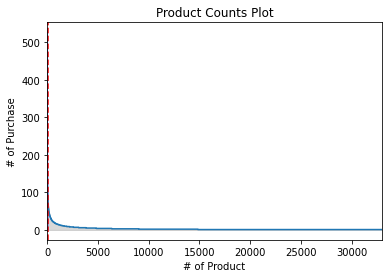

In [558]:
# plot purchase number of each product
plot_pdt_counts(df.product_id, cutoff=0.1)

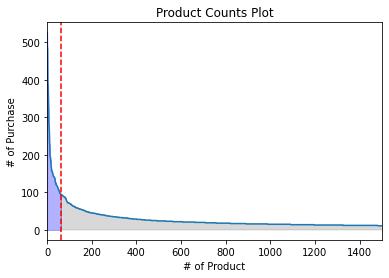

In [623]:
# plot purchase number of each product (zoom in)
plot_pdt_counts(df.product_id, cutoff=0.1, xlim=1500)

# Train Test Split

In [674]:
# convert 'order_purchase_timestamp' to datetime
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

In [675]:
def split_train_test(df: pd.DataFrame, user: str, time: str) -> Union[pd.DataFrame]:
    """
    create train and test set using leave one out method

    Parameters
    ----------
    df: pd.DataFrame
        The dataframe to be splitted
    user, time: str
        The column name of the user IDs and timestamp

    Returns
    -------
    dataframes
        train and test dataframes
    """

    # leave one out
    df["rank_latest"] = df.groupby([user])[time].rank(method="first", ascending=False)

    # filter latest purchase to create train and test set
    train = df[df.rank_latest != 1]
    test = df[df.rank_latest == 1]

    # keep only useful columns
    train.drop(columns=[time, "rank_latest"], inplace=True)
    test.drop(columns=[time, "rank_latest"], inplace=True)

    # print out the same of both sets
    print(f"Shape of the train set: {train.shape}")
    print(f"Shape of the test set: {test.shape}")

    return train, test

In [676]:
# create train and test set
df_train, df_test = split_train_test(
    df, user="customer_id", time="order_purchase_timestamp"
)

Shape of the train set: (17230, 5)
Shape of the test set: (95420, 5)


In [677]:
# calcaulte the number of users who bought more than once
print(
    f"Number of common users: {len(set(df_train.customer_id).intersection(df_test.customer_id))}"
)

Number of common users: 11869


# Define PyTorch Dataset

In [606]:
class BuildDataset(Dataset):
    """
    Build PyTorch Dataset for Training

    Parameters
    ----------
    df: pd.DataFrame
        The dataframe to be used building the dataset
    all_item_ids: list
        List containing all item IDs

    """

    def __init__(self, df: pd.DataFrame, all_item_ids: list):
        """
        Balance and initialize the training data and labels
        """
        (
            self.users,
            self.cities,
            self.items,
            self.weights,
            self.labels,
        ) = self.generate_neg(df, all_item_ids)

    def __len__(self):
        """
        Returns the number of samples in the training data
        """
        return len(self.users)

    def __getitem__(self, idx):
        """
        Loads and returns a sample from the dataset with the given index.
        """
        # user data
        uid = self.users[idx]
        city = self.cities[idx]

        # item data
        iid = self.items[idx]
        weight = self.weights[idx]

        sample = {
            "user_inputs": {"uid": uid, "city": city},
            "item_inputs": {"iid": iid, "weight": weight},
            "labels": self.labels[idx],
        }

        return sample

    def generate_neg(self, df: pd.DataFrame, all_item_ids: list):
        """
        Generate 4 random negative interactions for
        every purchase (positive interaction)
        """

        # training data placeholders
        users, cities, items, weights, labels = [], [], [], [], []

        # user-item interaction set that contains items that each user has interaction with
        user_item_set = set(zip(df["customer_id"], df["product_id"]))

        # 4:1 ratio of negative to positive samples
        num_neg = 4  # can be tuned
        for user, pos_item in user_item_set:

            # postive interactions
            users.append(user)
            cities.append(df["customer_city"][df["customer_id"] == user].iloc[0])
            items.append(pos_item)
            weights.append(df["product_weight_g"][df["product_id"] == pos_item].iloc[0])
            labels.append(1)  # items that the user has interacted with are positive

            # negative interactions
            for _ in range(num_neg):

                # randomly select an item
                neg_item = np.random.choice(all_item_ids)
                # check that the user has not interacted with this item
                while (user, neg_item) in user_item_set:
                    neg_item = np.random.choice(all_item_ids)

                # append results
                users.append(user)
                cities.append(df["customer_city"][df["customer_id"] == user].iloc[0])
                items.append(neg_item)
                weight_neg = df["product_weight_g"][df["product_id"] == neg_item]
                if len(weight_neg) > 1:
                    weights.append(weight_neg.iloc[0])
                else:
                    weights.append(weight_neg.item())
                labels.append(0)  # items not interacted with are negative

        return (
            torch.tensor(users),
            torch.tensor(cities),
            torch.tensor(items),
            torch.tensor(weights),
            torch.tensor(labels),
        )

# Define NCF Model

In [575]:
class TQDMProgressBar(TQDMProgressBar):
    def init_train_tqdm(self):
        bar = super().init_train_tqdm()
        bar.refresh_rate = 50
        return bar

## Simple NCF

In [774]:
class NCF_simple(pl.LightningModule):
    """
    Neural Collaborative Filtering (NCF) -- Simple version
    Only embed user and item IDs

    Parameters
    ----------
    attribute_max: dict
        Dictionary containing the maximum value of each attribute (feature)
    df: pd.DataFrame
        The dataframe to be used to train the model
        The dataframe containing the movie df
    all_item_ids: list
        List containing all item IDs
    embed_dim: int (Default is 8)
        Dimension of the embedding layer

    """

    def __init__(
        self,
        attribute_max: dict,
        df: pd.DataFrame,
        all_item_ids: list,
        embed_dim: int = 8,
    ):
        super(NCF_simple, self).__init__()

        # user embeddings
        self.embedding_uid = nn.Embedding(
            num_embeddings=attribute_max["uid"], embedding_dim=embed_dim
        )
        # item embeddings
        self.embedding_iid = nn.Embedding(
            num_embeddings=attribute_max["iid"], embedding_dim=embed_dim
        )

        # dense layer
        self.fc1 = nn.Linear(in_features=embed_dim*2, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)

        # BatchNorm layer
        self.BN = nn.BatchNorm1d(64)

        self.df = df
        self.all_item_ids = all_item_ids

    def forward(self, train_user, train_item):

        # unpack train_data
        uid = train_user["uid"]
        city = train_user["city"]

        iid = train_item["iid"]
        weight = train_item["weight"]

        # Pass through embedding layers
        user_embedded = self.embedding_uid(uid)
        item_embedded = self.embedding_iid(iid)

        # Concat the two embedding layers
        x = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        x = nn.ReLU()(self.fc1(x))
        x = self.BN(x)
        x = nn.ReLU()(self.fc2(x))

        # Output layer
        pred = nn.Sigmoid()(self.output(x))

        return pred

    def training_step(self, batch, batch_idx):
        predicted_labels = self(batch["user_inputs"], batch["item_inputs"])
        loss = nn.BCELoss()(predicted_labels, batch["labels"].view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(
            BuildDataset(self.df, self.all_item_ids),
            batch_size=512,
            num_workers=4,
        )

## Upgrade NCF

In [642]:
class NCF(pl.LightningModule):
    """
    Neural Collaborative Filtering (NCF) -- Upgrade version
    Embed user and item IDs and 2 more features

    Parameters
    ----------
    attribute_max: dict
        Dictionary containing the maximum value of each attribute (feature)
    df: pd.DataFrame
        The dataframe to be used to train the model
        The dataframe containing the movie df
    all_item_ids: list
        List containing all item IDs
    embed_dim: int (Default is 8)
        Dimension of the embedding layer

    """

    def __init__(
        self,
        attribute_max: dict,
        df: pd.DataFrame,
        all_item_ids: list,
        embed_dim: int = 8,
    ):
        super(NCF, self).__init__()

        # user embeddings
        self.embedding_uid = nn.Embedding(
            num_embeddings=attribute_max["uid"], embedding_dim=embed_dim
        )
        self.embedding_city = nn.Embedding(
            num_embeddings=attribute_max["city"], embedding_dim=embed_dim
        )

        # item embeddings
        self.embedding_iid = nn.Embedding(
            num_embeddings=attribute_max["iid"], embedding_dim=embed_dim
        )
        self.embedding_weight = nn.Embedding(
            num_embeddings=attribute_max["weight"], embedding_dim=embed_dim
        )

        # dense layer
        self.fc1 = nn.Linear(in_features=embed_dim*4, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)

        # BatchNorm layer
        self.BN = nn.BatchNorm1d(64)

        self.df = df
        self.all_item_ids = all_item_ids

    def forward(self, train_user, train_item):

        # unpack train_data
        uid = train_user["uid"]
        city = train_user["city"]

        iid = train_item["iid"]
        weight = train_item["weight"]

        # Pass through embedding layers
        user_embedded = self.embedding_uid(uid)
        city_embedded = self.embedding_city(city)
        item_embedded = self.embedding_iid(iid)
        weight_embedded = self.embedding_weight(weight.detach().clone().long())

        # Concat the two embedding layers
        x = torch.cat(
            [user_embedded, city_embedded, item_embedded, weight_embedded], dim=-1
        )

        # Pass through dense layer
        x = nn.ReLU()(self.fc1(x))
        x = self.BN(x)
        x = nn.ReLU()(self.fc2(x))

        # Output layer
        pred = nn.Sigmoid()(self.output(x))

        return pred

    def training_step(self, batch, batch_idx):
        predicted_labels = self(batch["user_inputs"], batch["item_inputs"])
        loss = nn.BCELoss()(predicted_labels, batch["labels"].view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(
            BuildDataset(self.df, self.all_item_ids),
            batch_size=512,
            num_workers=4,
        )

# Run and inference simple NCF model

In [792]:
# initialize metrics
MAP = RetrievalMAP()
MRR = RetrievalMRR()
precision = RetrievalPrecision(k=10)
recall = RetrievalRecall(k=10)

## Simple NCF

In [647]:
# get maximum value of each attribute
attribute_max = {
    "uid": df.customer_id.max() + 1,
    "city": df.customer_city.max() + 1,
    "iid": df.product_id.max() + 1,
    "weight": int(df.product_weight_g.max()) + 1,
}

# get a list of all item IDs
all_item_ids = df_train.product_id.unique()

# initilize model and Trainer
model_simple = NCF_simple(attribute_max, df_train, all_item_ids)
trainer_simple = pl.Trainer(
    max_epochs=1,
    gpus=None,
    reload_dataloaders_every_n_epochs=1,
    logger=False,
    callbacks=[TQDMProgressBar()],
    enable_checkpointing=False,
)

# train model
trainer_simple.fit(model_simple)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name          | Type        | Params
----------------------------------------------
0 | embedding_uid | Embedding   | 763 K 
1 | embedding_iid | Embedding   | 263 K 
2 | fc1           | Linear      | 1.1 K 
3 | fc2           | Linear      | 2.1 K 
4 | output        | Linear      | 33    
5 | BN            | BatchNorm1d | 128   
----------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.121     Total estimated model params size (MB)


In [776]:
def inference_result(model, test_cust_item_set: set, cust_interacted_items: list) -> dict:
    """

    Parameters
    ----------
    model
        Trained model used for inference
    test_cust_item_set: set
        Set containing cust-item pairs for testing
    cust_interacted_items: list
        Dictionary of all items that are interacted with by each customer

    Returns
    -------
    dictionary
        contaning different metrics
    """

    # declare variables
    preds = []
    target = []
    indexes = []
    count = 0

    for (u, c, i, w) in test_cust_item_set:

        # for each customer, randomly select 99 items that the customer has not interacted with.
        interacted_items = cust_interacted_items[u]
        not_interacted_items = set(all_item_ids) - set(interacted_items)
        selected_not_interacted = list(
            np.random.choice(list(not_interacted_items), 99, replace=False)
        )

        # Combine these 99 items with the test item: the actual item that the customer last interacted with.
        # The final test item list has 100 items
        test_items = selected_not_interacted + [i]
        test_weights = df[["product_id", "product_weight_g"]][
            df.product_id.isin(selected_not_interacted)
        ].drop_duplicates(subset=["product_id"])["product_weight_g"].to_list() + [w]

        test_user = {"uid": torch.tensor([u] * 100), "city": torch.tensor([c] * 100)}
        test_item = {
            "iid": torch.tensor(test_items),
            "weight": torch.tensor(test_weights),
        }

        # run the model on these 100 items
        predicted_labels = np.squeeze(model(test_user, test_item).detach().numpy())

        # save results
        preds.append(predicted_labels)
        target.append(np.concatenate((np.zeros(99), (1,))))
        indexes.append(np.array([count] * 100))

    # calculate metrics
    preds = torch.tensor(preds).ravel()
    target = torch.tensor(target).ravel()
    indexes = torch.tensor(indexes).ravel().long()

    metrics = {
        "MP": precision(preds=preds, target=target, indexes=indexes)
        .detach()
        .numpy()
        .round(6),
        "MRR": MRR(preds=preds, target=target, indexes=indexes)
        .detach()
        .numpy()
        .round(6),
        "MRecall": recall(preds=preds, target=target, indexes=indexes)
        .detach()
        .numpy()
        .round(6),
        "MAP": MAP(preds=preds, target=target, indexes=indexes)
        .detach()
        .numpy()
        .round(6),
    }
    return metrics

In [777]:
NCF_simple_metrics = inference_result(model_simple, test_cust_item_set, cust_interacted_items)

## Upgrade NCF

In [608]:
# initilize model and Trainer
model = NCF(attribute_max, df_train, all_item_ids)
trainer = pl.Trainer(
    max_epochs=1,
    gpus=None,
    reload_dataloaders_every_n_epochs=1,
    logger=False,
    callbacks=[TQDMProgressBar()],
    enable_checkpointing=False,
)

# train model
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name             | Type        | Params
-------------------------------------------------
0 | embedding_uid    | Embedding   | 763 K 
1 | embedding_city   | Embedding   | 32.9 K
2 | embedding_iid    | Embedding   | 263 K 
3 | embedding_weight | Embedding   | 323 K 
4 | fc1              | Linear      | 2.1 K 
5 | fc2              | Linear      | 2.1 K 
6 | output           | Linear      | 33    
7 | BN               | BatchNorm1d | 128   
-------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.550     Total estimated model params size (MB)


In [777]:
NCF_metrics = inference_result(model, test_cust_item_set, cust_interacted_items)

# Compare Results

In [806]:
df_results = pd.read_csv("../model/colab/results.csv", index_col=0)
df_results

,MP,MRR,MRecall,MAP
NCF_simple_metrics,0.000048,0.021845,0.000031,0.012949
NCF_metrics,0.000095,0.035910,0.000105,0.020011


In [807]:
# df_result = pd.DataFrame(
#     [NCF_simple_metrics, NCF_metrics], index=["NCF_simple_metrics", "NCF_metrics"]
# )
# df_result